# CNN CLASSIFIER

PURPOSE:
  - API to train and apply leveraged pretrained vision models for classification
  
REQUIREMENTS:
  - Pretained model is downloaded and can be trained on a dataset by user
  - The number of attached fully connected layers is customizable by the user
  - The deeper convolutional layers are unfrozen for a period of time during training for tuning
  - User can load a model and continue training or move directly to inference
  - Saved trained model information is stored in a specific folder with a useful naming convention
  - There are time-limited prompts that allow the user to direct processes as needed
  - Training performance can be tested before moving onward to inference if desired
  - Predictions are made using paralleled batches and are saved in a results dictionary
  
HOW TO USE:
  - If no model has been trained and saved, start by training a model
  - Store data in folders at this location: os.path.expanduser('~') + '/Programming Data/'
  - For training, 'train' and 'valid' folders with data are required in the data_dir
  - For overfit testing, an 'overfit' folder with data is required in the data_dir
  - For performance testing, a 'test' folder with data is required in the data_dir
  - For inference, put data of interest in a 'predict' folder in the data_dir
  - For saving and loading models, create a 'models' folder in the data_dir

## Import Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, os, random
import numpy as np
import json
import argparse
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from PIL import Image
from threading import Thread

## Import Prepared CNN Functions

In [3]:
from cnn_operational_functions  import *
from cnn_utility_functions import *
from cnn_model_functions import *

## Copy CNN Main Function

In [4]:
def main():
    '''
    # Retrieve command line arguments to dictate model type, training parameters, and data
    # Load image datasets, process the image data, and convert these into data generators
    # Create a default naming structure to save and load information at a specified directory
    # Download a pretrained model using input arguments and attach new fully connected output Layers
    # Define criterion for loss, if training is required by the input arg, execute the following:
    #    o Prompt user for overfit training, if yes, initiate training against pretrained features
    #    o Prompt user for complete training, if yes, initiate training against pretrained features
    #    o Save the hyperparameters, training history, and training state for the overfit and full models
    # If training is no requested by the input arg, execute the following:
    #    o Load in a pretrained model's state dict and it's model_hyperparameters
    #    o Display the training history for this model
    # Provide prompt to test the model and perform and display performance if requested
    # Provide prompt to apply the model towards inference and put model to work if requested
    # Show an example prediction from the inference
    '''
    # Call ArgumentParser for user arguments and store in arg
    data_dir = os.path.expanduser('~') + '/Programming Data/' + argdir + '/'

    # Call data processor to return a dictionary of datasets, the data labels, and the class labels
    dict_datasets, dict_data_labels, dict_class_labels = u2_load_processed_data(data_dir)

    # Call data iterator to convert dictionary of datasets to dictionary of dataloaders
    dict_data_loaders = u4_data_iterator(dict_datasets)

    #Create file pathway and naming convention saving and loading files in program
    file_name_scheme =  data_dir + 'models/' + os.path.basename(os.path.dirname(data_dir))\
                    + '_' + argmodel + '_' + str(arglayer) + 'lay'
    
    # Call create classifier to return a model leveraging a desired pretrained architecture, define loss criterion
    model = m1_create_classifier(argmodel, arglayer, len(dict_datasets['train_data'].classes))
    criterion = nn.NLLLoss()

    # Define start condition hyperparameters and key running information such as elapsed training time
    # epoch_on and running_count refer to the epoch in which deeper layers started training and for how long
    model_hyperparameters = {'learnrate': arglearn,
                         'training_loss_history': [],
                         'validate_loss_history': [],
                         'epoch_on': [],
                         'running_count': 0,
                         'weightdecay' : 0.00001,
                         'training_time' : 0}

    # If user requests load, call load checkpoint to return model and hyperparameters, then plot loaded information
    if argload == 'y':
        model, model_hyperparameters = m3_load_model_checkpoint(model, file_name_scheme)
        o5_plot_training_history(argmodel, model_hyperparameters, file_name_scheme)
        o8_plt_display(argauto)

    # If user requests train, first display an example piece of data from the processed training set
    if argtrain == 'y':
        # NOTE 1: Processed data is tensor shape [xpixel, ypixel, colour], matplotlib takes order [c, x, y], so we transpose
        # NOTE 2: Plotted images blocks function continuation, unblock requires pause to load image or image will freeze
        print('Displaying an example processed image from the training set..\n')
        plt.imshow(random.choice(dict_datasets['train_data'])[0].numpy().transpose((1, 2, 0))) # NOTE: 1
        o8_plt_display(argauto)

        # Call train model with model and training dataset to return trained model and hyperparameters, then plot and save
        model, model_hyperparameters = o1_train_model(model, dict_data_loaders['train_loader'],
                        dict_data_loaders['valid_loader'], argepoch, 0.6, model_hyperparameters, criterion)
        o5_plot_training_history(argmodel, model_hyperparameters, file_name_scheme, 'complete')
        o8_plt_display(argauto)

        # Prompt user to save, save the model and its hyperparameters per the naming convention
        if u5_time_limited_input('Would you like to save the model?'):
            m2_save_model_checkpoint(model, file_name_scheme, model_hyperparameters)

    # If user requests no load and no train, prompt to run an overfit training exercise and execute if requested
    # NOTE: Same as training but on an overfit dataset. overfit_model metadata references the same data as the model metadata
    if argtrain == 'n' and argload == 'n':
        if u5_time_limited_input('Check model can overfit small dataset?'):
            overfit_model, overfit_model_hyperparameters = o1_train_model(model, dict_data_loaders['overfit_loader'],
                            dict_data_loaders['valid_loader'], argepoch, 0.9, model_hyperparameters, criterion)
            o5_plot_training_history(argmodel, overfit_model_hyperparameters, file_name_scheme, 'overfit')
            o8_plt_display(argauto)

    # If user requests load, or has requested training and training has completed, the model is ready for predictions
    if argtrain == 'y' or argload == 'y':
        print('The model is ready to provide predictions\n')

        # Prompt to test the model's performance
        # Gives the testing data loader to the validation function and returns performance
        if u5_time_limited_input('Would you like to test the model?'):
            t0 = time.time()
            test_count_correct, ave_test_loss = o3_model_no_backprop(model, dict_data_loaders['test_loader'], criterion)
            print('\nTesting Loss: {:.3f}.. '.format(ave_test_loss),
                'Testing Accuracy: {:.3f}'.format(test_count_correct / len(dict_data_loaders['test_loader'].dataset)),
                'Runtime - {:.0f} seconds\n'.format((time.time() - t0)))

        # Prompt the user to use the model for inference
        # Gives an unlabeled dataloader to a predict function and returns predictions
        if u5_time_limited_input('Would you like to use the model for inference?'):
            t1 = time.time()
            dict_prediction_results = o6_predict_data(model, dict_data_loaders['predict_loader'],
                            dict_data_labels, dict_class_labels)
            print('Runtime - {:.0f} seconds\n'.format((time.time() - t1)),
                            [dict_prediction_results[key][0][0] for key in dict_prediction_results])
            o7_show_prediction(data_dir, dict_prediction_results, argauto)

## Define Arguments


Using  googlenet  with the following attached  2  layer classifier:
 Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Loaded model learnrate = 2.39e-10.. Loaded model training time = 227 min



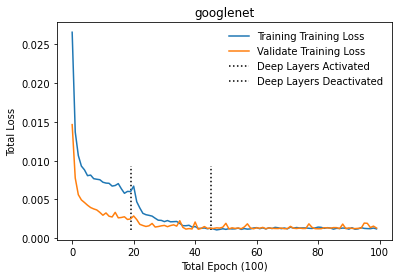

The model is ready to provide predictions

Would you like to test the model?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes



C:\Users\lukea\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Testing Loss: 0.001..  Testing Accuracy: 0.956 Runtime - 16 seconds

Would you like to use the model for inference?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes

Runtime - 0 seconds
 ['pink primrose', 'bird of paradise', 'monkshood', 'hard-leaved pocket orchid', 'pink primrose', 'bird of paradise', 'magnolia', 'english marigold', 'tiger lily', 'tiger lily', 'tiger lily', 'bird of paradise', 'hard-leaved pocket orchid', 'tiger lily', 'bird of paradise', 'hard-leaved pocket orchid', 'monkshood', 'bird of paradise', 'hard-leaved pocket orchid', 'tiger lily', 'tiger lily', 'moon orchid', 'pink primrose', 'english marigold', 'tiger lily', 'balloon flower', 'english marigold', 'tiger lily', 'globe thistle', 'moon orchid', 'bird of paradise', 'balloon flower', 'globe thistle', 'sweet pea', 'moon orchid', 'moon orchid', 'sweet pea', 'english marigold', 'bird of paradise', 'canterbury bells', 'sweet pea', 'sweet pea', 'bird of paradise', 'bird of paradise', 'canterbury b

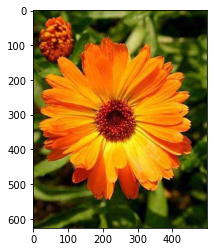

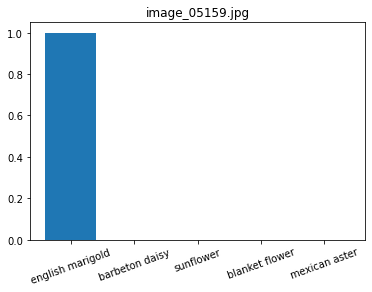


Using  googlenet  with the following attached  2  layer classifier:
 Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Loaded model learnrate = 1.40e-04.. Loaded model training time = 14 min



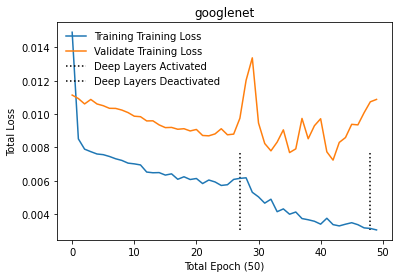

The model is ready to provide predictions

Would you like to test the model?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes


Testing Loss: 0.025..  Testing Accuracy: 0.635 Runtime - 1 seconds

Would you like to use the model for inference?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes

Runtime - 0 seconds
 ['normal', 'benign', 'malignant']


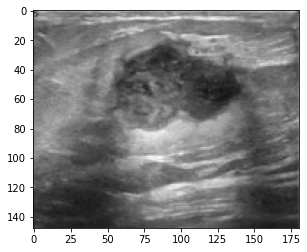

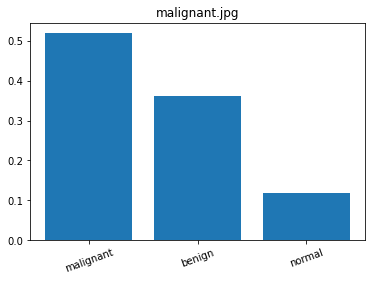


Using  googlenet  with the following attached  2  layer classifier:
 Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Loaded model learnrate = 3.00e-03.. Loaded model training time = 10 min



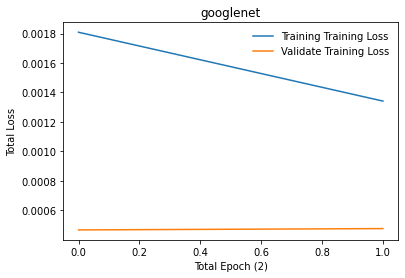

The model is ready to provide predictions

Would you like to test the model?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes


Testing Loss: 0.000..  Testing Accuracy: 0.977 Runtime - 56 seconds

Would you like to use the model for inference?: 'y' for yes, 'n' for no (10 seconds to choose): y
User input = Yes

Runtime - 1 seconds
 ['cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'c

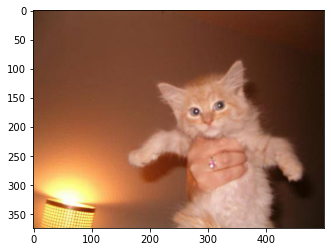

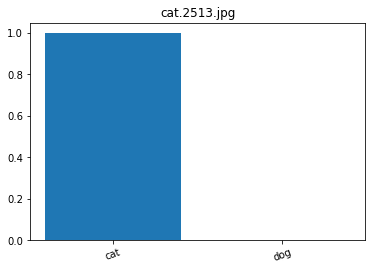

<Figure size 432x288 with 0 Axes>

In [5]:
'''
ArgParse Not Used in Notebooks

def u1_get_input_args(): 
    Purpose:
        - Creates and stores command line arguments inputted by the user.
        - Attaches default arguments and help text to aid user.
    Command Line Arguments:
        1. Data directory as --dir
        2. Choose to load model as --load
        3. Choose to train model as --train
        4. Define number of training epochs as --epoch
        5. Define network number of hidden layers --layer
        6. Define learnrate as --learn
        7. Choose pretrained CNN model as --model
    Returns:
        - Stored command line arguments as an Argument Parser Object with parse_args() data structure
'''
models = ['vgg', 'alexnet', 'googlenet', 'densenet', 'inception', 'resnext', 'shufflenet']
directories = ['Flower_data', 'Ultrasound_Nomask_data', 'Cat_Dog_data']

# SELECT ARGUMENTS
argauto = 'y'
argload = 'y'
argtrain = 'n'
argepoch = 50
arglayer = 2
arglearn = 0.003
argmodel = 'googlenet'

# RUN MODEL
for directory in directories:
    argdir = directory
    main()